# Impacts anaylsis
## (Impact analysis - excluding domestic trade)
### Jeffrey Zhou
### 17/10/2022

In [24]:
import pymrio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''
Data setup --> imported from Z_analysis
Note: this will take a while to run. Something like 3 mins
'''

exio3 = pymrio.parse_exiobase3(path='/Users/jeffreyzhou/Desktop/MRIO/Data/IOT_2022_pxp.zip')
all_regions = exio3.get_regions()
all_sectors = exio3.get_sectors()

#include all missing calculations with calc_all()
exio3.calc_all()

#US Z matrix - transaction matrix
us_z = exio3.Z.aggregate('US')

#US Y matrix - final demand matrix
us_y = exio3.Y.aggregate('US')

trade_matrix_dict = {}
count = 0
lower_bound = 0
upper_bound = 200

for region in all_regions:
    trade_matrix_dict[region] = us_z.iloc[lower_bound:upper_bound]
    lower_bound += 200
    upper_bound += 200

demand_matrix_dict = {}
count = 0
lower_bound = 0
upper_bound = 200

for region in all_regions:
    demand_matrix_dict[region] = us_y.iloc[lower_bound:upper_bound]
    lower_bound += 200
    upper_bound += 200

trade_calcvalues_dict = {}
    
for region in all_regions:
    tm = trade_matrix_dict[region]
    d = {}
    for sector in all_sectors:
        d[sector] = tm[sector].values.sum()
    in_series = pd.Series(data = d, index = all_sectors)
    trade_calcvalues_dict[region] = in_series

US_total_trade = {}

for sector in all_sectors:
    in_dict = {}
    for region in all_regions:
        if region == 'US': # comment out this line if including domestic inputs
            continue
        in_dict[region] = trade_calcvalues_dict[region][sector]
    US_total_trade[sector] = in_dict

In [35]:
#function that plots graphs of specific width and height.

def plot_func(x, y, xlabel, ylabel, title):
    fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(111)
    ax.bar(x,y)
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)

    
    plt.show()

### Note from Jeff: Exiobase3 provides 2 impact matrices, one for "production" and one for "exports". Not sure what the difference is. Will use "production" going forwards

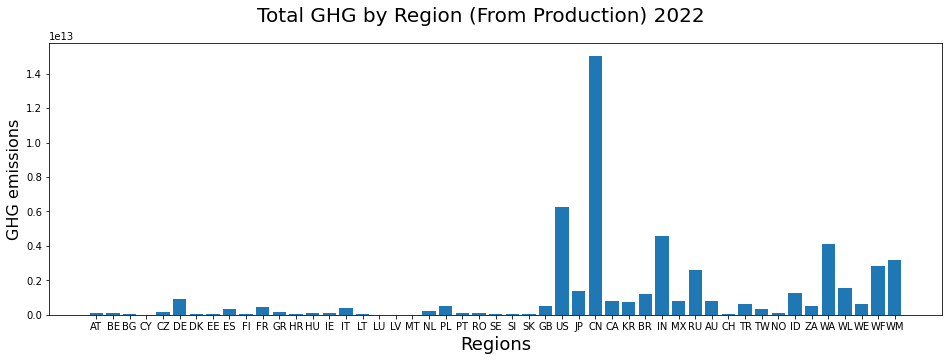

In [46]:
regional_prod_ghg = exio3.impacts.D_pba_reg.loc['GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)']
plot_func(all_regions, regional_prod_ghg.to_list(), 'Regions', 'GHG emissions', "Total GHG by Region (From Production) 2022")

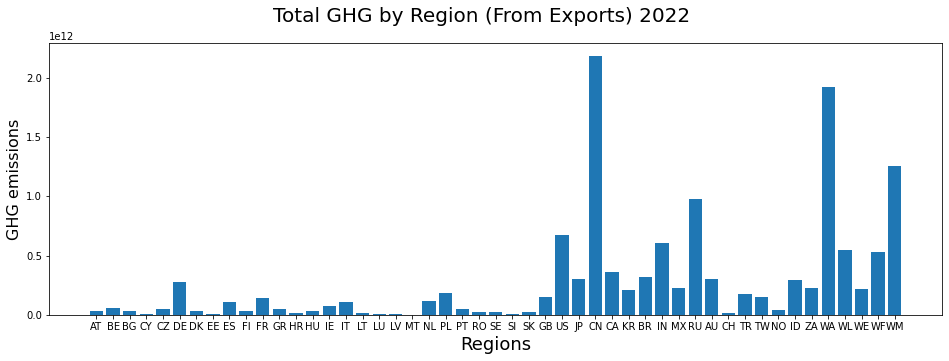

In [45]:
regional_exp_ghg = exio3.impacts.D_exp_reg.loc['GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)']
plot_func(all_regions, regional_exp_ghg.to_list(), 'Regions', 'GHG emissions', "Total GHG by Region (From Exports) 2022")

In [91]:
#total produciton output of every region AND every sector 
All_region_total_output = exio3.x.to_dict()['indout']
US_total_trade['Wheat']['AT']/ All_region_total_output[('AT', 'Wheat')] * exio3.impacts.D_pba.AT.Wheat.loc['GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)']

114577.10854294876

In [ ]:
#US Imported goods impacts (GHG) calculation. Will take every region input into every US sector and mulitply it by local_emissions * import_amount/total_production

exio3.impacts.D_imp.US

- 'US_total_trade[sector][region]' - gets the dollar(?) value of SECTOR imports from REGION to the US. 
- 'exio3.impacts.D_imp.US' - gets the enviromental impacts of imports into US. Note: unsure of how this is calculated.
- 'All_region_total_output' - Dict[(region, sector)] that gets the total PRODUCTION for each SECTOR in REGION
- 'exio3.impacts.D_pba[region][sector]' - total enviromental impact of ALL PRODUCTION for each SECTOR in REGION 

## Formula: GHG emissions per imported SECTOR into US = (US_total_trade[sector][region] / All_region_total_output[(region, sector)]) * exio3.impacts.D_pba[region][sector].loc[~GHG~]

In [127]:
US_importsector_ghg = {}


for sector in all_sectors:
    sum1 = 0
    for region in all_regions:
        if region == 'US':
            continue
        if All_region_total_output[(region, sector)] == 0:
            continue
        
        sum1 += US_total_trade[sector][region] * exio3.impacts.D_pba[region][sector].loc['GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)']/All_region_total_output[(region, sector)]
        US_importsector_ghg[sector] = sum1


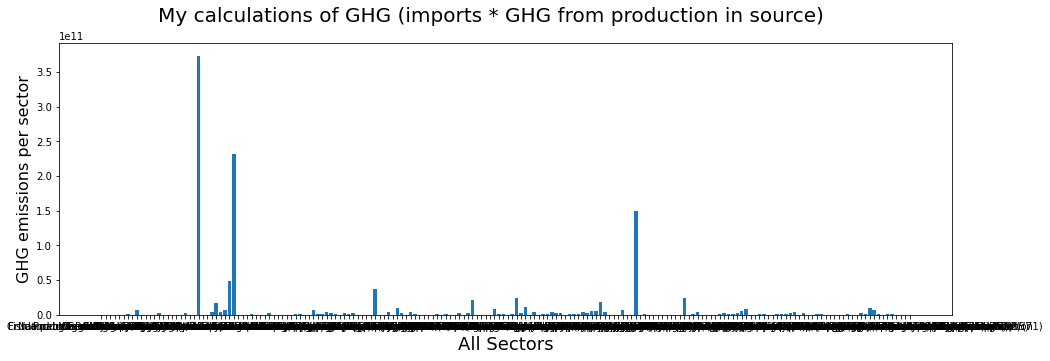

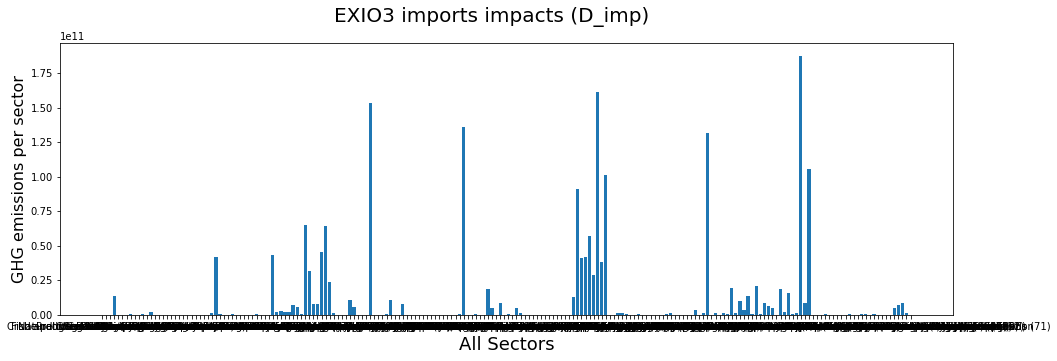

In [158]:
x, y1 = zip(*US_importsector_ghg.items())
plot_func(x, y1, 'All Sectors', 'GHG emissions per sector', 'My calculations of GHG (imports * GHG from production in source)')

y2 = exio3.impacts.D_imp.US.loc['GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)'].to_list()
plot_func(all_sectors, y2, 'All Sectors', 'GHG emissions per sector', 'EXIO3 imports impacts (D_imp)')